<a href="https://colab.research.google.com/github/maicon-reis/outspoken-market-na-pratica/blob/main/Sistema_Especialista_com_DBSCAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Sistema Especialista com DBSCAN

 

#### Etapas


- Passo 1 - Instalar e carregar a ta-lib

- Passo 2 - Carregar a base de dados

- Passo 3 - Ajustes e Construção dos alvos

- Passo 4 - Preparação dos dados e AED

- Passo 5 - Treinamento do DBSCAN e análise das regras

- Passo 6 - Regra de trade e avaliação dos resultados

________________________________________________________


### Passo 1 - Instalar e carregar a ta-lib

In [3]:
#pip install ta-lib

# Não use o pip install para a ta-lib. Faça
# conda install -c conda-forge ta-lib no prompt do Anaconda

# https://pypi.org/project/TA-Lib/

In [4]:
# No Google Colab a instalação da biblioteca se dá com:
!pip install -q talib-binary

In [5]:
# Carregando as bibliotecas

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.metrics import pairwise_distances
from sklearn.neighbors import NearestNeighbors
import statsmodels.api as sm
from statsmodels.formula.api import ols
import talib
get_ipython().run_line_magic("matplotlib", "inline")
import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


______________________________________________________

### Passo 2 - Carregar a base de dados

In [6]:
# Carregando a base de dados e fazendo os checks iniciais
csv_file = "https://raw.githubusercontent.com/maicon-reis/financas_quantitativas/main/arquivos/ibov-2000_2021"

df = pd.read_csv(csv_file, usecols=["Date", "Open", "High", "Low", "Close", "Adj Close"]) # Não usarei a coluna de Volume

# Modificando o formato da data
df['Date'] = pd.to_datetime(df["Date"]).dt.normalize()

# Configurando a data como índice
df.set_index("Date", inplace=True) # Vou manter a coluna de datas no índice e como variável
df.index.name = "Data"

______________________________________________________

### Passo 3 - Ajustes e Construção dos alvos

In [7]:
# Construção dos alvos

# Alvo 1 - Retorno
df["Retorno"] = np.log(df["Adj Close"] / df['Adj Close'].shift(1))
df["Alvo1"] = df["Retorno"].shift(-1)

# Alvo 5 - Retorno
df["Retorno5"] = np.log(df["Adj Close"] / df['Adj Close'].shift(5))
df["Alvo5"] = df["Retorno5"].shift(-5)

# Alvo 10 - Retorno
df["Retorno10"] = np.log(df["Adj Close"] / df['Adj Close'].shift(10))
df["Alvo10"] = df["Retorno10"].shift(-10)

# Criacao dos alvos categoricos
df["Alvo1_cat"] = np.where(df["Alvo1"] > 0 , 1, 0)
df["Alvo5_cat"] = np.where(df["Alvo5"] > 0 , 1, 0)
df["Alvo10_cat"] = np.where(df["Alvo10"] > 0 , 1, 0)

# Verificando os dados
df.head(10)

,Open,High,Low,Close,Adj Close,Retorno,Alvo1,Retorno5,Alvo5,Retorno10,Alvo10,Alvo1_cat,Alvo5_cat,Alvo10_cat
Data,,,,,,,,,,,,,,
2000-01-03,17098.0,17408.0,16719.0,16930.0,16930.0,NaN,-0.065855,NaN,0.005419,NaN,0.064225,0,1,1
2000-01-04,16908.0,16908.0,15851.0,15851.0,15851.0,-0.065855,0.024553,NaN,0.044542,NaN,0.121736,1,1,1
2000-01-05,15871.0,16302.0,15350.0,16245.0,16245.0,0.024553,-0.008531,NaN,0.022641,NaN,0.072700,0,1,1
2000-01-06,16237.0,16499.0,15977.0,16107.0,16107.0,-0.008531,0.012463,NaN,0.071337,NaN,0.064317,1,1,1
2000-01-07,16125.0,16449.0,16125.0,16309.0,16309.0,0.012463,0.042790,NaN,0.079472,NaN,0.043494,1,1,1
2000-01-10,16325.0,17057.0,16325.0,17022.0,17022.0,0.042790,-0.026732,0.005419,0.058805,NaN,-0.002942,0,1,0
2000-01-11,17045.0,17197.0,16573.0,16573.0,16573.0,-0.026732,0.002651,0.044542,0.077193,NaN,0.031596,1,1,1
2000-01-12,16574.0,16724.0,16331.0,16617.0,16617.0,0.002651,0.040165,0.022641,0.050059,NaN,0.027540,1,1,1
2000-01-13,16663.0,17715.0,16663.0,17298.0,17298.0,0.040165,0.020598,0.071337,-0.007020,NaN,-0.033148,1,0,0


______________________________________________________

### Passo 4 - Preparação dos dados e AED

In [8]:
# Verificando todos os padrões de candle
padroes = talib.get_function_groups()["Pattern Recognition"]
padroes

['CDL2CROWS',
 'CDL3BLACKCROWS',
 'CDL3INSIDE',
 'CDL3LINESTRIKE',
 'CDL3OUTSIDE',
 'CDL3STARSINSOUTH',
 'CDL3WHITESOLDIERS',
 'CDLABANDONEDBABY',
 'CDLADVANCEBLOCK',
 'CDLBELTHOLD',
 'CDLBREAKAWAY',
 'CDLCLOSINGMARUBOZU',
 'CDLCONCEALBABYSWALL',
 'CDLCOUNTERATTACK',
 'CDLDARKCLOUDCOVER',
 'CDLDOJI',
 'CDLDOJISTAR',
 'CDLDRAGONFLYDOJI',
 'CDLENGULFING',
 'CDLEVENINGDOJISTAR',
 'CDLEVENINGSTAR',
 'CDLGAPSIDESIDEWHITE',
 'CDLGRAVESTONEDOJI',
 'CDLHAMMER',
 'CDLHANGINGMAN',
 'CDLHARAMI',
 'CDLHARAMICROSS',
 'CDLHIGHWAVE',
 'CDLHIKKAKE',
 'CDLHIKKAKEMOD',
 'CDLHOMINGPIGEON',
 'CDLIDENTICAL3CROWS',
 'CDLINNECK',
 'CDLINVERTEDHAMMER',
 'CDLKICKING',
 'CDLKICKINGBYLENGTH',
 'CDLLADDERBOTTOM',
 'CDLLONGLEGGEDDOJI',
 'CDLLONGLINE',
 'CDLMARUBOZU',
 'CDLMATCHINGLOW',
 'CDLMATHOLD',
 'CDLMORNINGDOJISTAR',
 'CDLMORNINGSTAR',
 'CDLONNECK',
 'CDLPIERCING',
 'CDLRICKSHAWMAN',
 'CDLRISEFALL3METHODS',
 'CDLSEPARATINGLINES',
 'CDLSHOOTINGSTAR',
 'CDLSHORTLINE',
 'CDLSPINNINGTOP',
 'CDLSTALLEDPATTERN',
 

In [9]:
df["CDL2CROWS"] = talib.CDL2CROWS(df["Open"], df["High"], df["Low"], df["Close"])
df["CDL3BLACKCROWS"] = talib.CDL3BLACKCROWS(df["Open"], df["High"], df["Low"], df["Close"])
df["CDL3INSIDE"] = talib.CDL3INSIDE(df["Open"], df["High"], df["Low"], df["Close"])
df["CDL3LINESTRIKE"] = talib.CDL3LINESTRIKE(df["Open"], df["High"], df["Low"], df["Close"])
df["CDL3OUTSIDE"] = talib.CDL3OUTSIDE(df["Open"], df["High"], df["Low"], df["Close"])
df["CDL3STARSINSOUTH"] = talib.CDL3STARSINSOUTH(df["Open"], df["High"], df["Low"], df["Close"])
df["CDL3WHITESOLDIERS"] = talib.CDL3WHITESOLDIERS(df["Open"], df["High"], df["Low"], df["Close"])
df["CDLABANDONEDBABY"] = talib.CDLABANDONEDBABY(df["Open"], df["High"], df["Low"], df["Close"])
df["CDLADVANCEBLOCK"] = talib.CDLADVANCEBLOCK(df["Open"], df["High"], df["Low"], df["Close"])
df["CDLBELTHOLD"] = talib.CDLBELTHOLD(df["Open"], df["High"], df["Low"], df["Close"])
df["CDLBREAKAWAY"] = talib.CDLBREAKAWAY(df["Open"], df["High"], df["Low"], df["Close"])
df["CDLCLOSINGMARUBOZU"] = talib.CDLCLOSINGMARUBOZU(df["Open"], df["High"], df["Low"], df["Close"])
df["CDLCONCEALBABYSWALL"] = talib.CDLCONCEALBABYSWALL(df["Open"], df["High"], df["Low"], df["Close"])
df["CDLCOUNTERATTACK"] = talib.CDLCOUNTERATTACK(df["Open"], df["High"], df["Low"], df["Close"])
df["CDLDARKCLOUDCOVER"] = talib.CDLDARKCLOUDCOVER(df["Open"], df["High"], df["Low"], df["Close"])
df["CDLDOJI"] = talib.CDLDOJI(df["Open"], df["High"], df["Low"], df["Close"])
df["CDLDOJISTAR"] = talib.CDLDOJISTAR(df["Open"], df["High"], df["Low"], df["Close"])
df["CDLDRAGONFLYDOJI"] = talib.CDLDRAGONFLYDOJI(df["Open"], df["High"], df["Low"], df["Close"])
df["CDLENGULFING"] = talib.CDLENGULFING(df["Open"], df["High"], df["Low"], df["Close"])
df["CDLEVENINGDOJISTAR"] = talib.CDLEVENINGDOJISTAR(df["Open"], df["High"], df["Low"], df["Close"])
df["CDLEVENINGSTAR"] = talib.CDLEVENINGSTAR(df["Open"], df["High"], df["Low"], df["Close"])
df["CDLGAPSIDESIDEWHITE"] = talib.CDLGAPSIDESIDEWHITE(df["Open"], df["High"], df["Low"], df["Close"])
df["CDLGRAVESTONEDOJI"] = talib.CDLGRAVESTONEDOJI(df["Open"], df["High"], df["Low"], df["Close"])
df["CDLHAMMER"] = talib.CDLHAMMER(df["Open"], df["High"], df["Low"], df["Close"])
df["CDLHANGINGMAN"] = talib.CDLHANGINGMAN(df["Open"], df["High"], df["Low"], df["Close"])
df["CDLHARAMI"] = talib.CDLHARAMI(df["Open"], df["High"], df["Low"], df["Close"])
df["CDLHARAMICROSS"] = talib.CDLHARAMICROSS(df["Open"], df["High"], df["Low"], df["Close"])
df["CDLHIGHWAVE"] = talib.CDLHIGHWAVE(df["Open"], df["High"], df["Low"], df["Close"])
df["CDLHIKKAKE"] = talib.CDLHIKKAKE(df["Open"], df["High"], df["Low"], df["Close"])
df["CDLHIKKAKEMOD"] = talib.CDLHIKKAKEMOD(df["Open"], df["High"], df["Low"], df["Close"])
df["CDLHOMINGPIGEON"] = talib.CDLHOMINGPIGEON(df["Open"], df["High"], df["Low"], df["Close"])
df["CDLIDENTICAL3CROWS"] = talib.CDLIDENTICAL3CROWS(df["Open"], df["High"], df["Low"], df["Close"])
df["CDLINNECK"] = talib.CDLINNECK(df["Open"], df["High"], df["Low"], df["Close"])
df["CDLINVERTEDHAMMER"] = talib.CDLINVERTEDHAMMER(df["Open"], df["High"], df["Low"], df["Close"])
df["CDLKICKING"] = talib.CDLKICKING(df["Open"], df["High"], df["Low"], df["Close"])
df["CDLKICKINGBYLENGTH"] = talib.CDLKICKINGBYLENGTH(df["Open"], df["High"], df["Low"], df["Close"])
df["CDLLADDERBOTTOM"] = talib.CDLLADDERBOTTOM(df["Open"], df["High"], df["Low"], df["Close"])
df["CDLLONGLEGGEDDOJI"] = talib.CDLLONGLEGGEDDOJI(df["Open"], df["High"], df["Low"], df["Close"])
df["CDLLONGLINE"] = talib.CDLLONGLINE(df["Open"], df["High"], df["Low"], df["Close"])
df["CDLMARUBOZU"] = talib.CDLMARUBOZU(df["Open"], df["High"], df["Low"], df["Close"])
df["CDLMATCHINGLOW"] = talib.CDLMATCHINGLOW(df["Open"], df["High"], df["Low"], df["Close"])
df["CDLMATHOLD"] = talib.CDLMATHOLD(df["Open"], df["High"], df["Low"], df["Close"])
df["CDLMORNINGDOJISTAR"] = talib.CDLMORNINGDOJISTAR(df["Open"], df["High"], df["Low"], df["Close"])
df["CDLMORNINGSTAR"] = talib.CDLMORNINGSTAR(df["Open"], df["High"], df["Low"], df["Close"])
df["CDLONNECK"] = talib.CDLONNECK(df["Open"], df["High"], df["Low"], df["Close"])
df["CDLPIERCING"] = talib.CDLPIERCING(df["Open"], df["High"], df["Low"], df["Close"])
df["CDLRICKSHAWMAN"] = talib.CDLRICKSHAWMAN(df["Open"], df["High"], df["Low"], df["Close"])
df["CDLRISEFALL3METHODS"] = talib.CDLRISEFALL3METHODS(df["Open"], df["High"], df["Low"], df["Close"])
df["CDLSEPARATINGLINES"] = talib.CDLSEPARATINGLINES(df["Open"], df["High"], df["Low"], df["Close"])
df["CDLSHOOTINGSTAR"] = talib.CDLSHOOTINGSTAR(df["Open"], df["High"], df["Low"], df["Close"])
df["CDLSHORTLINE"] = talib.CDLSHORTLINE(df["Open"], df["High"], df["Low"], df["Close"])
df["CDLSPINNINGTOP"] = talib.CDLSPINNINGTOP(df["Open"], df["High"], df["Low"], df["Close"])
df["CDLSTALLEDPATTERN"] = talib.CDLSTALLEDPATTERN(df["Open"], df["High"], df["Low"], df["Close"])
df["CDLSTICKSANDWICH"] = talib.CDLSTICKSANDWICH(df["Open"], df["High"], df["Low"], df["Close"])
df["CDLTAKURI"] = talib.CDLTAKURI(df["Open"], df["High"], df["Low"], df["Close"])
df["CDLTASUKIGAP"] = talib.CDLTASUKIGAP(df["Open"], df["High"], df["Low"], df["Close"])
df["CDLTHRUSTING"] = talib.CDLTHRUSTING(df["Open"], df["High"], df["Low"], df["Close"])
df["CDLTRISTAR"] = talib.CDLTRISTAR(df["Open"], df["High"], df["Low"], df["Close"])
df["CDLUNIQUE3RIVER"] = talib.CDLUNIQUE3RIVER(df["Open"], df["High"], df["Low"], df["Close"])
df["CDLUPSIDEGAP2CROWS"] = talib.CDLUPSIDEGAP2CROWS(df["Open"], df["High"], df["Low"], df["Close"])
df["CDLXSIDEGAP3METHODS"] = talib.CDLXSIDEGAP3METHODS(df["Open"], df["High"], df["Low"], df["Close"])

In [10]:
# Cria mais variáveis: Volatilidade, Distância e Direções 
# Desvio Padrão de 10 dias

df["std10"] = df["Retorno"].rolling(10).std()

# Dist10 do fechamento
df["Dist_10"] = (df["Close"]/df["Close"].rolling(10).mean()) - 1

# Direção do dia atual
df["dir_D"] = np.where(df["Close"] > df["Open"] , 1, 0)

# Direção D-1
df["dir_D-1"] = df["dir_D"].shift(1)

# Direção D-2
df["dir_D-2"] = df["dir_D"].shift(2)

# Direção D-3
df["dir_D-3"] = df["dir_D"].shift(5)

# Direção D-4
df["dir_D-4"] = df["dir_D"].shift(10)

# Direção D-5
df["dir_D-5"] = df["dir_D"].shift(15)

# Média de altas dos últimos 10 dias
df["dir_D_mean"] = df["dir_D"].rolling(10).mean()

Vou verificar as ocorrências das variáveis decorrentes dos padrões de candle para excluir as variáveis com baixo número de ocorrências.

In [11]:
# Verificando as ocorrências dos padrões
for coluna in df.columns:
    print(df[coluna].value_counts())

66909.0     3
11784.0     3
61806.0     3
45533.0     3
65178.0     3
           ..
54396.0     1
54154.0     1
53852.0     1
54045.0     1
104863.0    1
Name: Open, Length: 5233, dtype: int64
13182.0     3
56974.0     3
54113.0     3
54236.0     3
10271.0     3
           ..
57666.0     1
57676.0     1
56544.0     1
55932.0     1
105190.0    1
Name: High, Length: 5220, dtype: int64
16883.0     3
53143.0     3
65925.0     3
37402.0     3
14490.0     3
           ..
52651.0     1
52098.0     1
50607.0     1
51271.0     1
103851.0    1
Name: Low, Length: 5233, dtype: int64
49246.0     3
14794.0     3
45533.0     3
56097.0     3
13570.0     3
           ..
52423.0     1
52078.0     1
51631.0     1
51738.0     1
104107.0    1
Name: Close, Length: 5255, dtype: int64
49246.0     3
14794.0     3
45533.0     3
56097.0     3
13570.0     3
           ..
52423.0     1
52078.0     1
51631.0     1
51738.0     1
104107.0    1
Name: Adj Close, Length: 5255, dtype: int64
 0.000000    5
 0.022482    1


In [12]:
# Excluindo as variáveis que apresentaram baixa ocorrência

df = df.dropna(axis = 0) 

df = df.drop(['CDL2CROWS', 'CDL3INSIDE', 'CDL3OUTSIDE'
            , 'CDL3STARSINSOUTH', 'CDL3WHITESOLDIERS', 'CDLBELTHOLD', 'CDLCLOSINGMARUBOZU'
            , 'CDL2CROWS', 'CDL3INSIDE', 'CDL3OUTSIDE', 'CDL3STARSINSOUTH'
            , 'CDL3WHITESOLDIERS', 'CDLBELTHOLD', 'CDLCLOSINGMARUBOZU'
            , 'CDLINVERTEDHAMMER', 'CDLKICKING', 'CDLKICKINGBYLENGTH', 'CDLMATCHINGLOW'
            , 'CDLMATHOLD', 'CDLMORNINGDOJISTAR', 'CDLONNECK', 'CDLRICKSHAWMAN'
            , 'CDLSPINNINGTOP', 'CDLSTALLEDPATTERN', 'CDLTAKURI', 'CDLTASUKIGAP'
            , 'CDLSPINNINGTOP', 'CDLTHRUSTING', 'CDLTRISTAR', 'CDLUNIQUE3RIVER'
                ], axis = 1)

# Removendo as demais colunas

df2 = df.drop(['Open', 'High', 'Low', 'Close', 'Retorno', 'Retorno5'
                , 'Retorno10', 'Alvo1', 'Alvo5', 'Alvo10'], axis = 1)

______________________________________________________

### Passo 5 - Treinamento do DBSCAN e análise das regras

In [13]:
# Separando os dados entre treinamento e teste

# Vamos treinar o modelo de 2000 a 2014
start_train = "2000-02-17"
end_train = "2014-12-31"

# Vamos testar o modelo de 2015 a 2021
start_test = "2015-01-01"
end_test = "2021-12-31"

# Separando os dados entre treino e teste
df_train = df.loc[start_train : end_train]
df_test = df.loc[start_test : end_test]

df2_train = df2.loc[start_train : end_train]
df2_test = df2.loc[start_test : end_test]

Vamos padronizar somentes os dados df2_train, pois, são nesses dados que será rodado o algoritmo DBSCAN. Na base de teste somente será utilizado o sistema especialista, não se fazendo necessária a padronização.

In [14]:
# Como o DBSCAN é sensível à dimensionalidade, vamos padronizar os dados

# Inicializa o scaler
scaler = StandardScaler()

# Padroniza o df sem NaNs
df2_train_padronizado = scaler.fit_transform(df2_train)

# Converte o array padronizado de volta para um dataframe
# com as mesmas colunas do outro dataframe
df2_train_padronizado = pd.DataFrame(df2_train_padronizado, columns = df2_train.columns)

### **Otimização dos Parâmetros**

Neste trecho busco fazer um GridSearch com objetivo de identificar os valores ótimos de min_samples e eps que obtenham o maior valor de afastamento de ruídos.

In [15]:
min_samples_range = range(5, 40, 5)
eps_range = np.round(np.arange(3.0, 6.1, 0.1), 2) # range funciona apenas com inteiros

def gs_avaliacao(eps, min_samples, dataframe, iteracoes):
    
    # Ajusta o modelo
    dbscan_model_gs = DBSCAN( eps = eps, min_samples = min_samples)
    dbscan_model_gs.fit(dataframe)
    
    # Identifica os ruídos
    ruidos = dbscan_model_gs.labels_ == -1
    
    if True in ruidos: # se existirem ruídos, calcula um KNN com 5
        knn = NearestNeighbors(n_neighbors = 5).fit(dataframe)
        distances, indices = knn.kneighbors(dataframe)
        dist_ruidos = distances[ruidos, 1:]
        dist_m_ruidos = round(dist_ruidos.mean(), 3)
    else:
        dist_m_ruidos = None
        
    # Verifica o número de clusters encontrados
    n_clusters = len(set(dbscan_model_gs.labels_[dbscan_model_gs.labels_ >= 0]))
    
    # Mostra os resultados
    print("%3d | eps = %3s e min_samples = %3s | %5s %4s" %
          (iteracoes, eps, min_samples, str(dist_m_ruidos), n_clusters))
        
    return(dist_m_ruidos, n_clusters)
    
# Para armazenar o resultado do grid search

# df vazio para armazenar a distância dos ruídos para o seus vizinhos
ruidos_gs = pd.DataFrame( 
      data = np.zeros((len(eps_range), len(min_samples_range)))
    , columns = min_samples_range
    , index = eps_range
)

# df vazio para as métricas do cluster
clusters_gs = pd.DataFrame( 
      data = np.zeros((len(eps_range), len(min_samples_range)))
    , columns = min_samples_range
    , index = eps_range
)

In [16]:
# Execução do GS

iteracao = 0

print("Iter| Parametros%s | Dist   Clus" % (" "*19))
print("-"*50)

for eps in eps_range:
    for min_samples in min_samples_range:
        
        iteracao += 1
        
        # Calculo das métricas
        ruido_res, cluster_res = gs_avaliacao(eps, min_samples, df2_train_padronizado, iteracao)
        
        # Adiciona os resultados nos dfs
        ruidos_gs.loc[eps, min_samples] = ruido_res
        clusters_gs.loc[eps, min_samples] = cluster_res

Iter| Parametros                    | Dist   Clus
--------------------------------------------------
  1 | eps = 3.0 e min_samples =   5 | 4.083   34
  2 | eps = 3.0 e min_samples =  10 |  3.61    6
  3 | eps = 3.0 e min_samples =  15 | 3.533    4
  4 | eps = 3.0 e min_samples =  20 | 3.454    2
  5 | eps = 3.0 e min_samples =  25 | 3.396    2
  6 | eps = 3.0 e min_samples =  30 | 3.352    1
  7 | eps = 3.0 e min_samples =  35 | 3.318    1
  8 | eps = 3.1 e min_samples =   5 | 4.284   33
  9 | eps = 3.1 e min_samples =  10 | 3.731   11
 10 | eps = 3.1 e min_samples =  15 | 3.578    2
 11 | eps = 3.1 e min_samples =  20 | 3.525    2
 12 | eps = 3.1 e min_samples =  25 | 3.473    1
 13 | eps = 3.1 e min_samples =  30 | 3.418    2
 14 | eps = 3.1 e min_samples =  35 | 3.386    1
 15 | eps = 3.2 e min_samples =   5 | 4.473   31
 16 | eps = 3.2 e min_samples =  10 | 3.908   20
 17 | eps = 3.2 e min_samples =  15 | 3.657    3
 18 | eps = 3.2 e min_samples =  20 | 3.575    2
 19 | eps = 3.2 e

Criando gráficos de heatmap entre os resultads eps e Min Sample, que permita uma fácil visualização da Distância entre os pontos de ruído (gráfico da esquerda) e os clusters criados (gráfico da direita) para que possamos buscar os parâmetros que otimizem a maior distância entre os pontos de ruído criando o menor número de clusters possível.

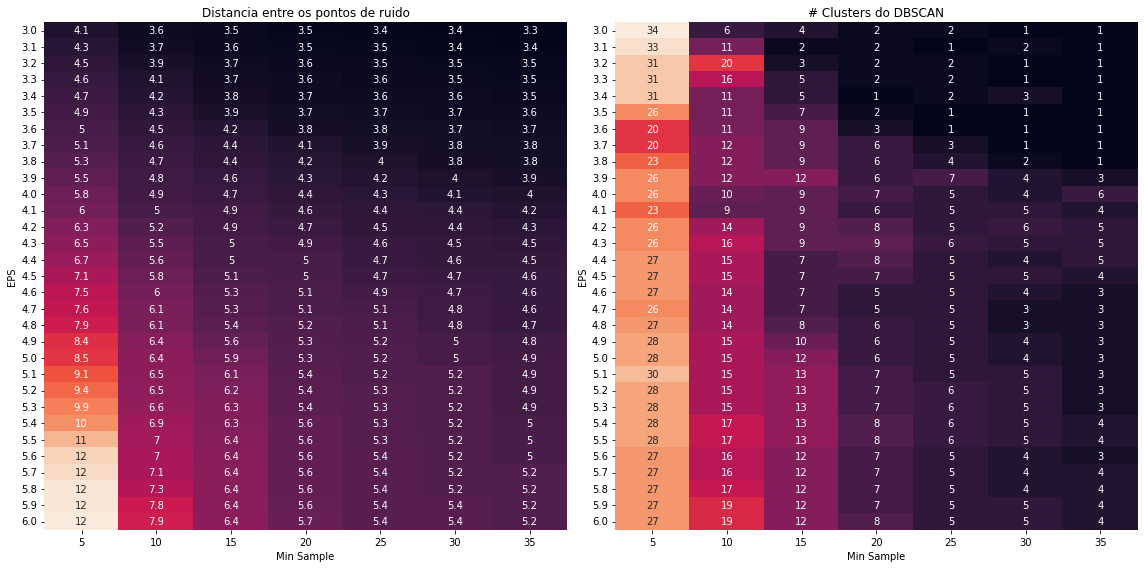

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (16, 8))

sns.heatmap(ruidos_gs, annot = True, ax = ax1, cbar = False).set_title("Distancia entre os pontos de ruido")
sns.heatmap(clusters_gs, annot = True, ax = ax2, cbar = False).set_title("# Clusters do DBSCAN")

ax1.set_xlabel("Min Sample")
ax1.set_ylabel("EPS")
ax2.set_xlabel("Min Sample")
ax2.set_ylabel("EPS")

plt.tight_layout();
plt.show()

In [18]:
# Inicializa o modelo

dbscan_model = DBSCAN(eps = 5.6, min_samples = 30)  #25

# Treinamento

dbscan_model.fit(df2_train_padronizado)

# Acessando os clusters
# O -1 representa os ruídos/outliers assim como no R

clusters = dbscan_model.labels_
clusters

array([ 0,  0,  0, ..., -1,  0,  0])

Como a análise, a partir desse ponto, será feita na base de dados original. Eu criei uma coluna chamada ```cluster``` no dataframe df2_train, e, juntamente inclui os alvos para os períodos que serão analisados.

In [19]:
# Inserindo-os no df2 junto com os Alvos

df2_train_padronizado["cluster"] = clusters
df2_train["cluster"] = clusters
df2_train["Alvo1"] = df_train["Alvo1"]*100
df2_train["Alvo5"] = df_train["Alvo5"]*100
df2_train["Alvo10"] = df_train["Alvo10"]*100
df2_train.head(3)

,Adj Close,Alvo1_cat,Alvo5_cat,Alvo10_cat,CDL3BLACKCROWS,CDL3LINESTRIKE,CDLABANDONEDBABY,CDLADVANCEBLOCK,CDLBREAKAWAY,CDLCONCEALBABYSWALL,...,dir_D-1,dir_D-2,dir_D-3,dir_D-4,dir_D-5,dir_D_mean,cluster,Alvo1,Alvo5,Alvo10
Data,,,,,,,,,,,,,,,,,,,,,
2000-02-17,17979.0,0,0,1,0,0,0,0,0,0,...,1.0,1.0,1.0,1.0,0.0,0.6,0,-1.988606,-1.135518,0.205584
2000-02-18,17625.0,1,1,1,0,0,0,0,0,0,...,0.0,1.0,0.0,1.0,0.0,0.5,0,0.424629,0.914950,5.556218
2000-02-21,17700.0,0,0,1,0,0,0,0,0,0,...,0.0,0.0,0.0,1.0,0.0,0.5,0,-1.199253,-0.890963,3.240703


In [20]:
# Verificando a quantidade de valores por clusters
df2_train["cluster"].value_counts()

 0    3171
-1     381
 1      54
 3      38
 2      36
Name: cluster, dtype: int64

In [21]:
df2_train["std10_q"] = np.where(df2_train["std10"] <= df2_train.std10.quantile(0.25)
                                                                  , -1
                                , np.where(df2_train["std10"] >= df2_train.std10.quantile(0.75)
                                                                  , 1, 0)
                               )

df2_train["Dist_10_q"] = np.where(df2_train["Dist_10"] <= df2_train.Dist_10.quantile(0.25)
                                                                  , -1
                                , np.where(df2_train["Dist_10"] >= df2_train.Dist_10.quantile(0.75)
                                                                  , 1, 0)
                               )

df2_train["dir_D_mean_q"] = np.where(df2_train["dir_D_mean"] <= df2_train.dir_D_mean.quantile(0.25)
                                                                  , -1
                                , np.where(df2_train["dir_D_mean"] >= df2_train.dir_D_mean.quantile(0.75)
                                                                  , 1, 0)
                               )

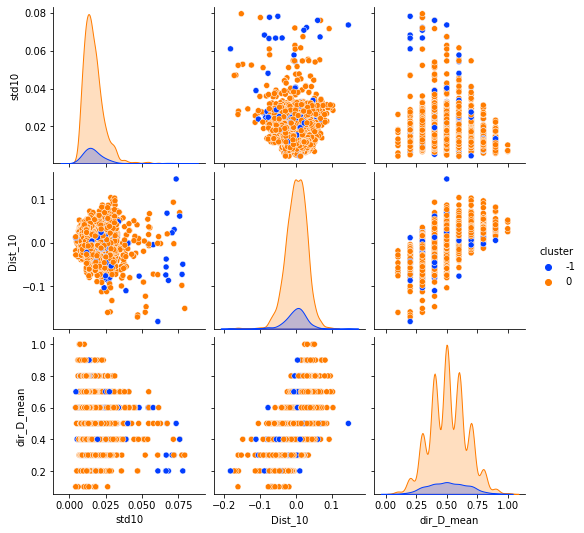

In [22]:
sns.pairplot(
    data = df2_train[
    ['std10', 'Dist_10', 'dir_D_mean', 'cluster']].loc[df2_train["cluster"] <= 0
    ]
    , hue = "cluster"
    , palette = "bright")
plt.show()

Nesse ponto do código farei a análise das regras do sistema especialista em si. Eu procurarei nos ruídos (-1) da coluna cluster, mesmo padrão de retornos nos alvos ocorridos no principal cluster (0).

Veja que eu salvo o dataframe de sistema de regras em um arquivo .xlsx para facilitar a análise.

In [23]:
df_dbscan = pd.pivot_table(df2_train.loc[df2_train["cluster"].isin([-1, 0])]
                            , index = ["cluster", "std10_q", "Dist_10_q"]
                            , values = ["Alvo1", "Alvo5", "Alvo10"]
                            , aggfunc = ([np.mean, np.sum], len))

# Salvando a tabela pivot em um arquivo xlsx
df_dbscan.to_excel("pivot_table_dbscan.xlsx")

# Visualizando a tabela
df_dbscan

Alvo1  \
                          <function mean at 0x7f54192714d0>   
cluster std10_q Dist_10_q                                     
-1      -1      -1                                -7.969703   
                 0                                14.390227   
                 1                                -0.148938   
         0      -1                               -11.177013   
                 0                               -25.383003   
                 1                                 0.005537   
         1      -1                                39.855463   
                 0                               -17.592262   
                 1                                -8.421779   
 0      -1      -1                                -9.149849   
                 0                               -36.008233   
                 1                                17.145919   
         0      -1                                56.896627   
                 0                                22.123060   
                 1                                26.508574   
         1      -1                                33.189032   
                 0                                35.870388   
                 1                                 3.936300   

                                                   \
                          <built-in function len>   
cluster std10_q Dist_10_q                           
-1      -1      -1                             12   
                 0                             59   
                 1                             11   
         0      -1                             44   
                 0                            117   
                 1                             38   
         1      -1                             34   
                 0                             39   
                 1                             27   
 0      -1      -1                            137   
                 0                            499   
                 1                            165   
         0      -1                            406   
                 0                            798   
                 1                            379   
         1      -1                            282   
                 0                            276   
                 1                            229   

                                                     Alvo10  \
                          <function mean at 0x7f54192714d0>   
cluster std10_q Dist_10_q                                     
-1      -1      -1                               -11.270822   
                 0                               -25.496954   
                 1                                14.373971   
         0      -1                                45.620317   
                 0                                82.457871   
                 1                                13.193391   
         1      -1                                63.623714   
                 0                               -49.712569   
                 1                               -28.021406   
 0      -1      -1                               -68.563482   
                 0                              -169.982473   
                 1                                39.474767   
         0      -1                               -62.952509   
                 0                               185.122995   
                 1                               244.454086   
         1      -1                               429.632274   
                 0                               277.101919   
                 1                               -17.132835   

                                                   \
                          <built-in function len>   
cluster std10_q Dist_10_q                           
-1      -1      -1                             12   
                 0                             59   
                 1         

______________________________________________________

### Passo 6 - Regra de trade e avaliação dos resultados

A partir da análise anterior eu crio um sitema de regras que servirá como "predict" para todo meu conjunto de dados.

In [24]:
df["Regra1"] = np.where(
    (df["Dist_10"].between(df2_train.Dist_10.quantile(0.25), df2_train.Dist_10.quantile(0.75))
    & (df["std10"] <= df2_train.std10.quantile(0.25))) , 1, 0)

df["Regra2"] = np.where(
    ((df["std10"] <= df2_train.std10.quantile(0.25)) 
             & (df["Dist_10"] >= df2_train.Dist_10.quantile(0.75)))
                            , 1, 0)

df["Regra3"] = np.where(
    ((df["std10"] >= df2_train.std10.quantile(0.75)) 
             & (df["Dist_10"] <= df2_train.Dist_10.quantile(0.25)))
                            , 1, 0)

# Verificando os dados
df.head()

,Open,High,Low,Close,Adj Close,Retorno,Alvo1,Retorno5,Alvo5,Retorno10,...,dir_D,dir_D-1,dir_D-2,dir_D-3,dir_D-4,dir_D-5,dir_D_mean,Regra1,Regra2,Regra3
Data,,,,,,,,,,,,,,,,,,,,,
2000-01-24,17049.0,17263.0,16972.0,16972.0,16972.0,-0.003646,0.007806,-0.061747,-0.026872,-0.002942,...,0,0.0,0.0,1.0,1.0,0.0,0.4,0,0,1
2000-01-26,16972.0,17105.0,16727.0,17105.0,17105.0,0.007806,-0.001404,-0.045597,-0.013952,0.031596,...,1,0.0,0.0,0.0,0.0,0.0,0.5,0,0,0
2000-01-27,17114.0,17422.0,17081.0,17081.0,17081.0,-0.001404,-0.020524,-0.022518,0.021774,0.027540,...,0,1.0,0.0,0.0,1.0,1.0,0.4,0,0,1
2000-01-28,17150.0,17252.0,16547.0,16734.0,16734.0,-0.020524,-0.020893,-0.026129,0.069144,-0.033148,...,0,0.0,1.0,0.0,1.0,0.0,0.3,0,0,0
2000-01-31,16744.0,16749.0,16167.0,16388.0,16388.0,-0.020893,0.008143,-0.038662,0.100798,-0.074640,...,0,0.0,0.0,0.0,1.0,1.0,0.2,0,0,0


In [25]:
# Calculando a performance - para toda a base
custo_op = 0.0001 
#0.01% - R$2 reais em R$20000, assumindo operação completa - C/V
#Cada ponto de um mini contrato de índice: R$0.20 - Assumindo então o indice em média de 100k pontos

df.loc[: , "Retorno_Modelo1"] = np.where( df["Regra1"] == 0
                                              , 0
                                              , df.loc[:, "Regra1"]*df["Alvo10"] - custo_op)

df.loc[: , "Retorno_Modelo2"] = np.where( df["Regra2"] == 0
                                              , 0
                                              , df.loc[:, "Regra2"]*df["Alvo10"] - custo_op)

df.loc[: , "Retorno_Modelo3"] = np.where( df["Regra3"] == 0
                                              , 0
                                              , df.loc[:, "Regra3"]*df["Alvo10"] - custo_op)

df.loc[: , "Retorno_Modelo"] = df["Retorno_Modelo2"] + df["Retorno_Modelo3"]

""


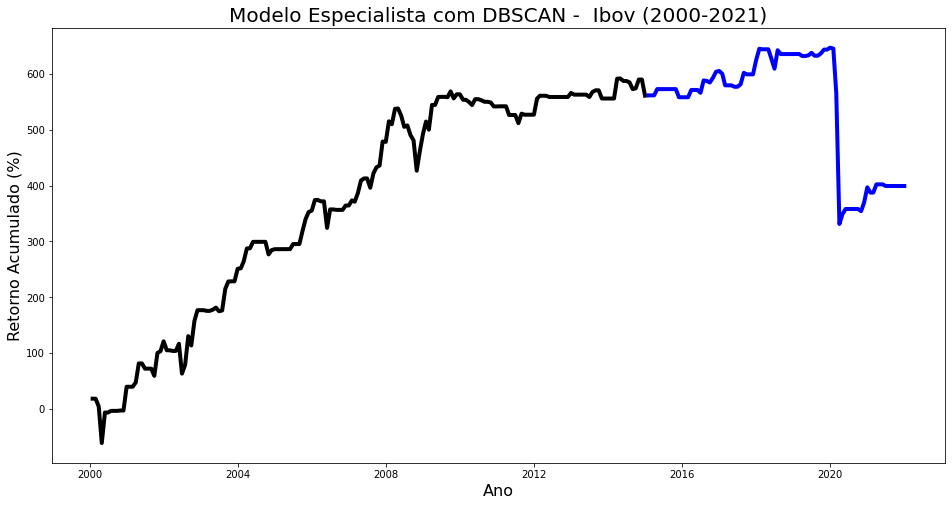

In [27]:
# Para fazer um conditional plot

df_plot = df.copy()

df_plot.index.name = "Data"
df_plot.reset_index(inplace = True)

df_plot["Data"] = pd.to_datetime(df_plot["Data"])

df_plot["train_test"] = np.where(df_plot["Data"] > end_train, 1, -1)

base_agregada = df_plot.resample("M", on = "Data").sum()

base_agregada.loc[: , "Retorno_Modelo_Acumulado"] = base_agregada["Retorno_Modelo"].cumsum()*100

# Plota o grafico
fig, ax = plt.subplots(figsize = (16, 8))

def grafico(group):
    color = "black" if (group["train_test"] < 0).all() else "blue"
    lw = 4.0
    ax.plot(group.index, group.Retorno_Modelo_Acumulado, c = color, linewidth = lw)
    plt.xlabel("Ano"
           , fontsize = 16);
    plt.ylabel("Retorno Acumulado (%)"
           , fontsize = 16);
    plt.title("Modelo Especialista com DBSCAN -  Ibov (2000-2021)", fontsize = 20)
    #plt.axvline( x = end_train, color='purple', linestyle = "--", lw = 2)

base_agregada.groupby((base_agregada["train_test"].shift() * base_agregada["train_test"] < 0).cumsum()).apply(grafico)



In [28]:
summary = df_plot.copy()
summary["Data"] = pd.to_datetime(summary["Data"], format = "%Y-%m")

summary = summary.groupby([summary["Data"].dt.year]).agg({"Retorno_Modelo": sum})

summary.index = summary.index.set_names(["Ano"])

summary*100

,Retorno_Modelo
Ano,
2000,39.506714
2001,81.490172
2002,55.794723
2003,74.238266
2004,35.106897
2005,69.182843
2006,9.091986
2007,114.136427
2008,13.616238
